In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_geom_median import *
import ciropt as co

In [2]:
# random seed
np.random.seed(1000)

# data generation
problem_spec = {}
problem_spec['n_node'] = 6
problem_spec['vector_size'] = 100
problem_spec['translation'] = "b"
# problem_spec['translation'] = "ran"
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()

problem_spec['sc_theta'] = 1

problem_data['rho'] = 1.
problem_data['itr_num'] = 1000

{'n_node': 6, 'vector_size': 100, 'translation': 'b'}


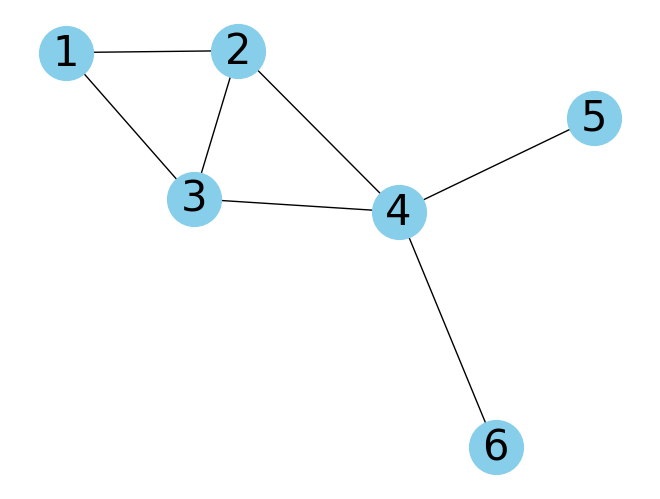

In [3]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True, font_size=30, node_size=1500)
# plt.savefig("plots/graph_n6.pdf")

In [4]:
f_star, x_opt_star = cvx_geom_median(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=337450.2964965265, np.linalg.norm(x_opt_star)=1031.3645295032086


In [5]:
b = problem_data['b']
c = problem_data['c']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']
theta = problem_spec['sc_theta']
prox_operators = []
fi_operators = []

for jj in range(n_node):
    bj = b[jj*vector_size : (jj+1)*vector_size]
    cj = c[jj*vector_size : (jj+1)*vector_size]
    if jj in [3, 4]:
        prox_operators += [lambda z, rho, bj=bj, cj=cj:  prox_fj_geom_mean_sc(z, rho, bj, cj, theta=theta)]
        fi_operators += [lambda x_kj, bj=bj, cj=cj: np.linalg.norm((x_kj - bj), ord=2) + theta*np.linalg.norm(x_kj - cj, ord=2)**2]
    else:
        prox_operators += [lambda z, rho, bj=bj:  prox_fj_geom_mean(z, rho, bj)]
        fi_operators += [lambda x_kj, bj=bj: np.linalg.norm((x_kj - bj), ord=2)]

    # Testing the validity of proximals
    z = np.random.randn(vector_size)
    a = 1
    x1 = prox_fj_geom_mean(z, a, bj)
    x2 = cvx_prox_fj_geom_mean(z, a, bj, vector_size)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

    x1 = prox_fj_geom_mean_sc(z, a, bj, cj, theta=theta)
    x2 = cvx_prox_fj_geom_mean_sc(z, a, bj, cj, vector_size, theta=theta)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-3

In [6]:
R = 0.6
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.2028325002142355, err_opt_reldiff[-1]=0.9235700993264728
ii=200, f_reldiff[-1]=1.247121110200895e-13, err_opt_reldiff[-1]=3.4443199843681364e-07
ii=400, f_reldiff[-1]=1.247121110200895e-13, err_opt_reldiff[-1]=3.444319983668095e-07
ii=600, f_reldiff[-1]=1.247121110200895e-13, err_opt_reldiff[-1]=3.4443199833933867e-07
ii=800, f_reldiff[-1]=1.247121110200895e-13, err_opt_reldiff[-1]=3.444319983319821e-07
ii=999, f_reldiff[-1]=1.247121110200895e-13, err_opt_reldiff[-1]=3.44431998282551e-07


In [7]:
# apply P-EXTRA 
problem_data['rho'] = 1
pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_dgeom_median(None, problem_spec, problem_data, network_data, x_opt_star, f_star, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.9170598562007405, err_opt_reldiff[-1]=0.715238721374914
ii=200, f_reldiff[-1]=6.775675349604049e-08, err_opt_reldiff[-1]=1.3965509921857952e-06
ii=400, f_reldiff[-1]=8.719498218624516e-13, err_opt_reldiff[-1]=2.350261005593774e-07
ii=600, f_reldiff[-1]=1.247121110200895e-13, err_opt_reldiff[-1]=2.3502419078190755e-07
ii=800, f_reldiff[-1]=1.247121110200895e-13, err_opt_reldiff[-1]=2.350241927979397e-07
ii=999, f_reldiff[-1]=1.2505709611281452e-13, err_opt_reldiff[-1]=2.3502419480372277e-07


In [8]:
# params={"R":0.8, "Inductance":2, "Capacitance":15, "h":3.51541700023903}
# dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
#                                                                                 network_data, x_opt_star, f_star, prox_operators=prox_operators,
#                                                                                 fi_operators=fi_operators,
#                                                                                 params=params, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.34467941946451575, err_opt_reldiff[-1]=0.9206720718021699
ii=200, f_reldiff[-1]=1.247121110200895e-13, err_opt_reldiff[-1]=3.4443199875201815e-07
ii=400, f_reldiff[-1]=1.247121110200895e-13, err_opt_reldiff[-1]=3.444319987268046e-07
ii=600, f_reldiff[-1]=1.247121110200895e-13, err_opt_reldiff[-1]=3.444319987665283e-07
ii=800, f_reldiff[-1]=1.247121110200895e-13, err_opt_reldiff[-1]=3.4443199877488836e-07
ii=999, f_reldiff[-1]=1.247121110200895e-13, err_opt_reldiff[-1]=3.444319988138631e-07


In [15]:
params={"R":0.8, "Inductance":1.2, "Inductance_S":1.2, "Capacitance":15, "h":3.51541700023903}
# params={"R":0.8, "Inductance":1.2, "Inductance_S":0.9, "Capacitance":20, "h":3.5}

# dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff = co.dadmm("cir_dadmm_c2", problem_spec, problem_data, 
#                                                                                 network_data, x_opt_star, f_star, prox_operators=prox_operators,
#                                                                                 fi_operators=fi_operators,
#                                                                                 params=params, printing=True, freq=200)

In [16]:
fname = "n6_circuit_dadmm_c_theta%s"%str(problem_spec['sc_theta'])

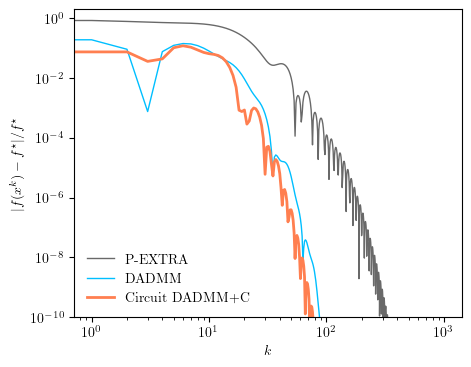

In [17]:
T = 1000
co.plot_methods([pg_f_reldiff[:T] ,admm_f_reldiff[:T], dadmm_c_f_reldiff[:T]],
                ['P-EXTRA', 'DADMM','Circuit DADMM+C'], 1e-10, 2e-0, fname)

In [12]:
np.where(np.array(dadmm_c_f_reldiff) < 1e-10)[0][0]

72

In [13]:
np.where(np.array(admm_f_reldiff) < 1e-10)[0][0]

88

In [14]:
np.where(np.array(pg_f_reldiff) < 1e-10)[0][0]

304